In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DL/project

/content/drive/MyDrive/DL/project


In [ ]:
import os
import torch
import torchvision

import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from random import sample
from torchsummary import summary
from torch.utils.data import Dataset, Subset
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.io import read_image
from torchvision.utils import make_grid 
from torchvision.datasets import ImageFolder
from sklearn.metrics import f1_score

In [ ]:
torch.cuda.manual_seed(1234)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(dataset)

In [ ]:
lung_dataset = 'lung_colon_image_set/lung_image_sets/'

In [ ]:
transforms_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Resize((64,64)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

transforms_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64,64)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

In [ ]:
dataset = ImageFolder(lung_dataset)

In [ ]:
train_set = CustomDataset(dataset,transforms_train)
val_set = CustomDataset(dataset,transforms_test)
test_set = CustomDataset(dataset,transforms_test)

# Create the index splits for training, validation and test
train_size = 0.8
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))
split2 = int(np.floor((train_size+(1-train_size)/2) * num_train))
np.random.shuffle(indices)
train_idx, valid_idx, test_idx = indices[:split], indices[split:split2], indices[split2:]

train_data = Subset(train_set, indices=train_idx)
val_data = Subset(val_set, indices=valid_idx)
test_data = Subset(test_set, indices=test_idx)

In [ ]:
batch_size = 64

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Cnn(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.conv_block = nn.Sequential(
          nn.Conv2d(3, 32, 3),
          nn.BatchNorm2d(32),
          nn.Dropout2d(0.2,inplace=True),
          nn.ReLU(inplace=True),

          nn.Conv2d(32, 64, 3, 2, padding=1),
          nn.BatchNorm2d(64),
          nn.Dropout2d(0.2,inplace=True),
          nn.ReLU(inplace=True),

          nn.MaxPool2d(2, 2),

          nn.Conv2d(64,128, 3, 2, padding=1),
          nn.BatchNorm2d(128),
          nn.Dropout2d(0.2,inplace=True),
          nn.ReLU(inplace=True),

          nn.MaxPool2d(2, 2),

          nn.Conv2d(128,256, 3, 2, padding=1),
          nn.BatchNorm2d(256),
          nn.Dropout2d(0.2,inplace=True),
          nn.ReLU(inplace=True),

          nn.MaxPool2d(2, 2),

          nn.Conv2d(256,512, 3, padding='same'),
          nn.ReLU(inplace=True),
        )
        self.dense_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.dense_block(x)
        return x

In [ ]:
# create model object, initialize loss and optimizer
net = Cnn(3)
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
# model summary to see number of trainable parameters
summary(net, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 62, 62]             896
       BatchNorm2d-2           [-1, 32, 62, 62]              64
         Dropout2d-3           [-1, 32, 62, 62]               0
              ReLU-4           [-1, 32, 62, 62]               0
            Conv2d-5           [-1, 64, 31, 31]          18,496
       BatchNorm2d-6           [-1, 64, 31, 31]             128
         Dropout2d-7           [-1, 64, 31, 31]               0
              ReLU-8           [-1, 64, 31, 31]               0
         MaxPool2d-9           [-1, 64, 15, 15]               0
           Conv2d-10            [-1, 128, 8, 8]          73,856
      BatchNorm2d-11            [-1, 128, 8, 8]             256
        Dropout2d-12            [-1, 128, 8, 8]               0
             ReLU-13            [-1, 128, 8, 8]               0
        MaxPool2d-14            [-1, 12

In [ ]:
def train():
    """Training loop
    """
    train_acc = []
    train_loss = 0.0
    correct = 0
    total = 0

    net.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(images)
        fit = criterion(outputs, labels)
        fit.backward()
        nn.utils.clip_grad_value_(net.parameters(), clip_value=0.1)
        optimizer.step()
        train_loss += fit.item()

        # accuracy
        _, pred = outputs.max(1)
        total += labels.size(0)
        correct += (pred == labels).sum()

        torch.cuda.empty_cache()

    loss = train_loss / len(train_loader)
    acc = float(correct)/float(total)

    print(f'Training loss: {loss}, Training acc: {acc}')

    return loss

def validate():
    """Validation loop
    """
    global best_loss
    val_acc = []
    val_loss = 0.0
    correct = 0
    total = 0

    net.eval()
    torch.cuda.empty_cache()
    for i, (images, labels) in enumerate(val_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = net(images)
        fit = criterion(outputs, labels)
        val_loss += fit.item()

        # accuracy
        _, pred = outputs.max(1)
        total += labels.size(0)
        correct += (pred == labels).sum()

        torch.cuda.empty_cache()

    loss = val_loss / len(val_loader)
    acc = float(correct)/float(total)

    print(f'Validation loss: {loss}, Validation acc: {acc}')

    return loss

In [ ]:
# driver cell to run train and validation methods
epochs = 25
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    print(f'Epoch {epoch}:')
    train_loss_history.append(train())
    val_loss_history.append(validate())
    # scheduler.step()
    print(f'*'*10)  

Epoch 0:
Training loss: 0.4459428205452067, Training acc: 0.8104166666666667
Validation loss: 0.31734177097678185, Validation acc: 0.8613333333333333
**********
Epoch 1:
Training loss: 0.2740821830056449, Training acc: 0.8865
Validation loss: 0.24660449847579002, Validation acc: 0.8913333333333333
**********
Epoch 2:
Training loss: 0.24221897882191426, Training acc: 0.89925
Validation loss: 0.3489824803546071, Validation acc: 0.8553333333333333
**********
Epoch 3:
Training loss: 0.23060242114390464, Training acc: 0.9063333333333333
Validation loss: 0.26854894310235977, Validation acc: 0.8933333333333333
**********
Epoch 4:
Training loss: 0.21069243562189824, Training acc: 0.91475
Validation loss: 0.22357746430983147, Validation acc: 0.9026666666666666
**********
Epoch 5:
Training loss: 0.20921743558125294, Training acc: 0.9155833333333333
Validation loss: 0.28062660060822964, Validation acc: 0.8846666666666667
**********
Epoch 6:
Training loss: 0.18932585491541218, Training acc: 0.9241

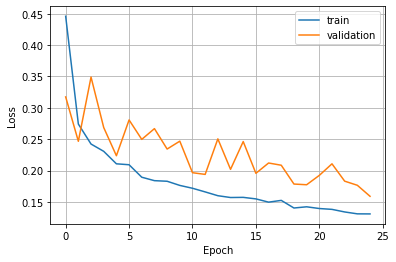

In [ ]:
# train-val loss curves
plt.plot(range(epochs), train_loss_history, '-', label="train")
plt.plot(range(epochs), val_loss_history, '-', label="validation")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig("cnn_lung.jpg")

In [ ]:
# test accuracy and f1 score
correct = 0
samples = 0
f1 = []
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)

        scores = net(images)
        _, pred = scores.max(1)
        f1.append(f1_score(labels.cpu(), pred.cpu(), average='macro'))
        correct += (pred == labels).sum()
        samples += pred.size(0)

        acc = float(correct)/float(samples)
    print(f'Test accuracy: {acc}')
    print(f'Test F1 score: {sum(f1)/len(f1)}')